# HST Spectroscopic Data of Luhman16ab
In this program spectroscopic Hubble Space Telescope data was aquired from MAST. The data is of brown dwarf binary Luhman16ab and the program demonstrates how to display the spectrum. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits 
from astroquery.mast import Observations

In [4]:
# search for data in MAST using astroquery
obs = Observations.query_criteria(obs_collection = 'hst', target_name = '2MASS-J10491891-5319100', 
                                  obsid = '26101019')
obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str6,str7,str3,str4,str8,str23,str20,str9,float64,float64,str8,str15,int64,float64,float64,float64,float64,float64,str71,float64,str5,str2,int64,str356,str34,str35,str6,bool,float64,str8,str9
science,HST,CALWF3,WFC3/IR,HST,G141,Infrared,2MASS-J10491891-5319100,STAR;BROWN DWARF;L;T,ica7a3030,162.3108097306,-53.31810828906,spectrum,"Buenzli, Esther",3,56604.44949903935,56604.4793790162,816.0,810.0,2009.9999999999998,Evolution of heterogeneous cloud structure through the T dwarf sequence,56969.82945595,13280,GO,--,POLYGON 162.30292064 -53.31634366 162.30292064 -53.31634367 162.31518888 -53.32080023 162.315821644353 -53.320177084431421 162.32352092 -53.31259313 162.32352093 -53.31259312 162.31125418 -53.30813741 162.31125415 -53.30813743 162.31112675566541 -53.308262907022446 162.31100306033645 -53.308384739728574 162.30292064 -53.31634366 162.30292064 -53.31634366,mast:HST/product/ica7a3031_drz.jpg,mast:HST/product/ica7a3031_drz.fits,PUBLIC,False,nan,26101019,366899176


In [5]:
# the table has only one entry so we will index the first entry
observation = obs['obsid'][0]

In [6]:
# download the data to the notebook directory
Observations.download_products(observation, download_dir='.', productFilename = 'ica7a3031_drz.fits')

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ica7a3030/ica7a3031_drz.fits,COMPLETE,None,None


In [7]:
def load_fits(img):
    '''
    loads fits data from HARPS spectrograph and outputs the header and data
    Parameters
    ----------
    img: string
        filename including path to a fits file
    Output
    ------
    data: np.ndarray[np.float64]
        NxM array of intensities
    header: 
        header of fits file
    '''
    hdu = fits.open(img)
    header = hdu[0].header
    data = (hdu[1].data).astype(np.float64)
    
    return data, header

data, header = load_fits('mastDownload/HST/ica7a3030/ica7a3031_drz.fits')

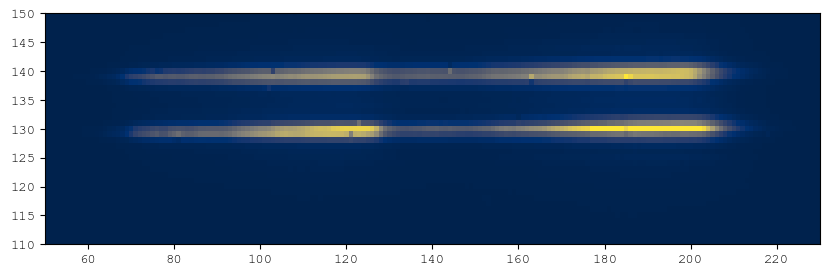

In [9]:
# display raw HST spectrum
plt.figure(figsize = (10,3))
plt.rcParams['font.family'] = 'courier new'
plt.imshow(data, vmax = 2500, cmap = 'cividis', origin = 'lower', aspect = 'auto')
plt.xlim(50, 230)
plt.ylim(110,150)
plt.show()

Luhman16a:


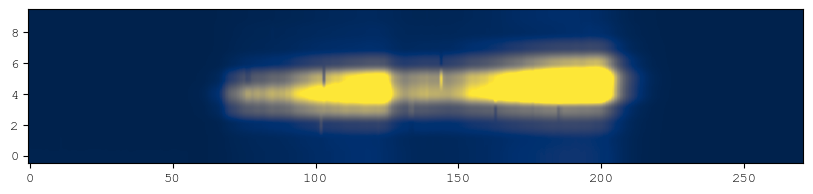

Luhman16b:


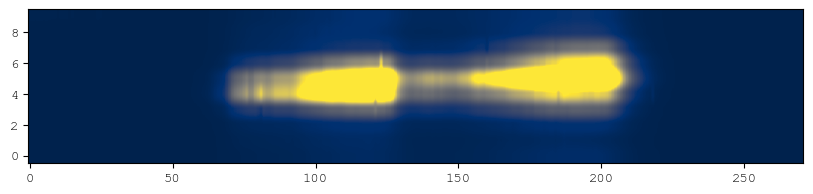

In [10]:
# crop data to extract Luhman 16b raw spectra counts
print('Luhman16a:')
luhman16a = data[135:145, :]
vmin = np.percentile(luhman16a, 1)
vmax = np.percentile(luhman16a, 95)
plt.figure(figsize = (10,2))
plt.rcParams['font.family'] = 'courier new'
plt.imshow(luhman16a, vmin = vmin, vmax = vmax, cmap = 'cividis', origin = 'lower', aspect = 'auto')
plt.show()
print('Luhman16b:')
luhman16b = data[125:135, :]
vmin = np.percentile(luhman16b, 1)
vmax = np.percentile(luhman16b, 95)
plt.figure(figsize = (10,2))
plt.rcParams['font.family'] = 'courier new'
plt.imshow(luhman16b, vmin = vmin, vmax = vmax, cmap = 'cividis', origin = 'lower', aspect = 'auto')
plt.show()

In [11]:
def compute_spectral_order_model(data, offset = 0):
    '''
    computes a 3rd order polynomial modeling the curvature of a spectral order
    Parameter
    ---------
    data: np.ndarray[np.float64]
        nxm array representing a spectral order from a slice of a NxM fits data array
    offset: int
        offset to shift the y-indices of the maximum values back to their original scale
        offset is equal to the lower bound of the array slice
        this is necessary as the input slice starts from 0, but the original data may have 
        a different starting index
    Output
    ------
    x_pixels: np.ndarray[np.int64]
        (m,) shaped array representing the range of x pixel values in the fits image 
    max_flux: np.ndarray[np.int64]
        (m,) shaped array representing the indeces of the maximum y values along the x axis
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    Example
    -------
        order_slice = data_cube[0][700:800, :]
        x_pixels, model = compute_spectral_order_model(order_slice, offset = 700)
        plt.plot(x_pixels, model(x_pixels))
    '''
    # for each x pixel in the input array, find the index of the max y value
    max_flux = np.argmax(data, axis = 0) + int(offset)
    # create array with range ϵ[0, max_flux.shape[0])
    x_pixels = np.arange(max_flux.shape[0])
    # compute coefficients of 3rd order polynomial
    coefficients = np.polyfit(x_pixels, max_flux, 3)
    model = np.poly1d(coefficients)
    
    return x_pixels, max_flux, model

x_pixels, max_flux_a, model_a = compute_spectral_order_model(luhman16a, offset = 135)
x_pixels, max_flux_b, model_b = compute_spectral_order_model(luhman16b, offset = 125)

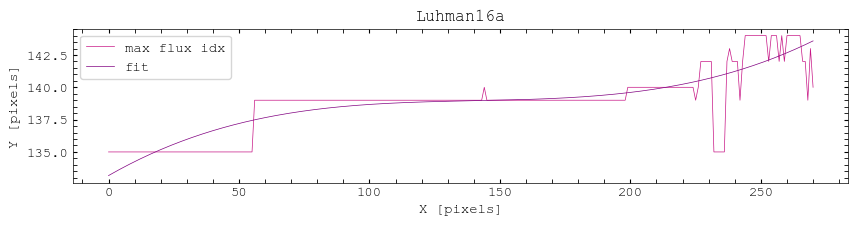

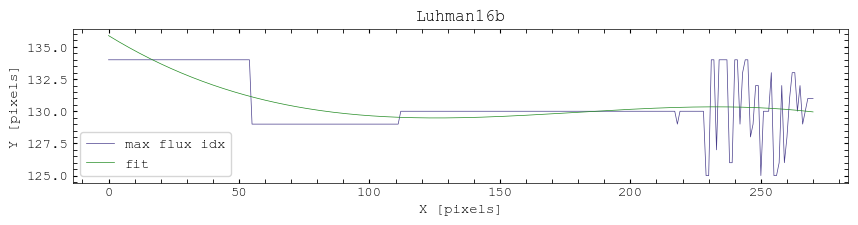

In [12]:
plt.figure(figsize = (10, 2))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['axes.linewidth'] = 0.5
plt.minorticks_on()
plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
plt.plot(x_pixels, max_flux_a, c = 'mediumvioletred', lw = 0.5, label = 'max flux idx')
plt.plot(x_pixels, model_a(x_pixels), c = 'purple', lw = 0.5, label = 'fit')
plt.title('Luhman16a')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend()
plt.show()

plt.figure(figsize = (10, 2))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['axes.linewidth'] = 0.5
plt.minorticks_on()
plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
plt.plot(x_pixels, max_flux_b, c = 'darkslateblue', lw = 0.5, label = 'max flux idx')
plt.plot(x_pixels, model_b(x_pixels), c = 'forestgreen', lw = 0.5, label = 'fit')
plt.title('Luhman16b')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend()
plt.show()

In [13]:
def extract_spectral_continuum(data, x_pixels, model):
    '''
    extracts the continuum flux of a spectral order by summing flux values 
    within a ±7 pixel window centered around the peak of each x-pixel
    Parameter
    ---------
    data: np.ndarray[np.float64]
        NxM stacked continuum image
    x_pixels: np.ndarray[np.int64]
        (m,) shaped array representing the range of x pixel values in the fits image 
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    Output
    ------
    extracted_continuum: np.ndarray[np.float64]
        (M,) shaped array representing the normalized extracted spectral order at every x_pixel value
        this is the raw extracted spectrum flux before wavelength calibration
    '''
    # 15xN data array to store the flux values in a ±7 pixel window centered at the peak y index of each x-pixel
    continuum_array = np.zeros((15, data.shape[1]))
    # 15x1 array of values in range ϵ[-7, 7] to broadcast a ±7 pixel window across all x pixels
    offset_range = np.arange(-7, 8)[:, np.newaxis]
    # compute indeces of the maximum flux values for each x pixel, rounded to the nearest integer
    max_flux_idx = np.round(model(x_pixels)).astype(int)
    # compute a 15xN array of y-indices, where each row represents an offset from the peak flux position
    flux_window_idx = max_flux_idx + offset_range
    # extract the spectral continuum by indexing the data array using computed y-indices and x-pixels
    continuum_array = data[flux_window_idx, x_pixels]
    # sum the flux values along the y axis into a (N,) shaped array
    extracted_continuum = np.sum(continuum_array, axis = 0)
    # normalize the extracted continuum
    extracted_continuum = extracted_continuum / np.max(extracted_continuum)
    
    return extracted_continuum

luhman16a_spec = extract_spectral_continuum(data, x_pixels, model_a)
luhman16b_spec = extract_spectral_continuum(data, x_pixels, model_b)

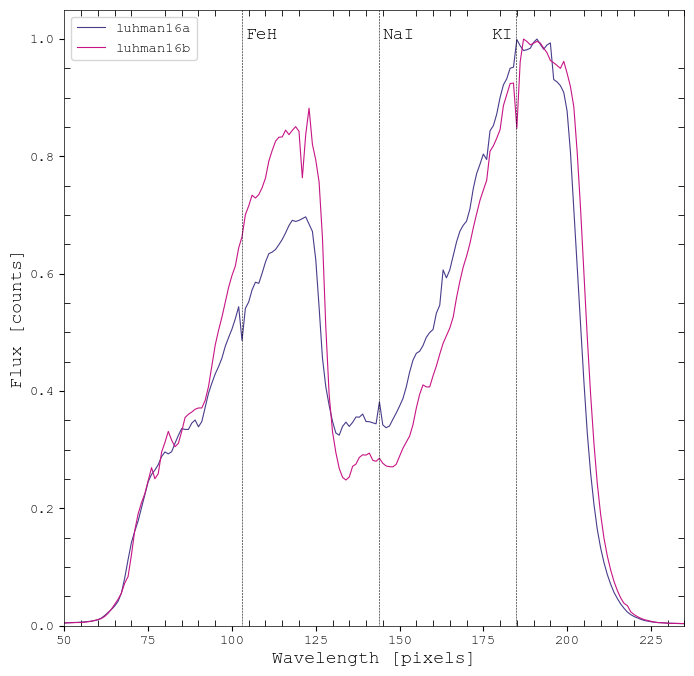

In [39]:
fig, ax = plt.subplots(figsize = (8, 8))
plt.rcParams['font.family'] = 'Courier New'
plt.rcParams['axes.linewidth'] = 0.5
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)

ax.plot(luhman16a_spec, 'darkslateblue', lw = 0.8, label = 'luhman16a')
ax.plot(luhman16b_spec, 'mediumvioletred', lw = 0.8, label = 'luhman16b')

ax.vlines(102.9, -0.5, 1.05, lw = 0.4, ls = '--', color = 'k')
ax.text(104, 1.0, 'FeH', fontsize = 13, fontweight = 'ultralight')
plt.vlines(143.8, -0.5, 1.05, lw = 0.4, ls = '--', color = 'k')
plt.text(144.8, 1.0, 'NaI', fontsize = 13, fontweight = 'ultralight')
plt.vlines(184.8, -0.5, 1.05, lw = 0.4, ls = '--', color = 'k')
plt.text(177.5, 1.0, 'KI', fontsize = 13, fontweight = 'ultralight')

ax.set_xlabel('Wavelength [pixels]', size = 13)
ax.set_ylabel('Flux [counts]', size = 13)
ax.set_xlim(50, 235)
ax.set_ylim(0, 1.05)
plt.legend(loc = 'upper left')
plt.show()

The image below is a spectroscopic image of Luhman 16ab from Kellogg, Kendra, and Metchev (2017). The leftmost spectra is very similar to the one obtained in this HST data analysis!
<br>
<br>
Citation: Kellogg, Kendra & Metchev, Stanimir & Heinze, Aren & Gagné, Jonathan & Kurtev, Radostin. (2017). Characterizing The Cloud Decks of Luhman 16AB with Medium-Resolution Spectroscopic Monitoring. The Astrophysical Journal. 849. 10.3847/1538-4357/aa8e4f. 

<img src="The-R-4000-Magellan-FIRE-spectra-of-the-Luhman-16A-and-B-components-from-2014-February.png" alt="Luhman 16 Spectra" width="1000">
